In [1]:
from keras.models import Model
from keras import backend as K
from keras.layers import LSTM, Input, Dense, Activation, Add, Reshape, Lambda, Concatenate, \
                         TimeDistributed, Bidirectional, Masking

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from keras.models import load_model

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from collections import Counter

In [4]:
from corpus import *

In [111]:
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import class_weight
from tqdm import tqdm

In [194]:
import numpy as np
seed = 7
np.random.seed(seed)

In [6]:
corpus = MTCorpus()

In [7]:
docs, links = corpus.documents, corpus.links
assert len([i for l in links for i in l]) == sum((len(d) for d in docs))

In [8]:
np.where(np.array([len(d) for d in docs]) > 6)

(array([ 56,  94, 107]),)

Counter({5: 71, 6: 24, 4: 11, 3: 3, 7: 2, 10: 1})


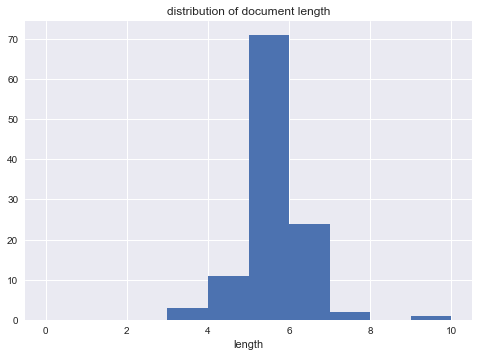

In [57]:
plt.title('distribution of document length')
plt.xlabel('length')
print(Counter([len(d) for d in docs]))
plt.hist([len(d) for d in docs],np.arange(11),);

Counter({1: 259, 3: 96, 5: 76, 2: 55, 4: 51, 6: 37, 7: 1, 9: 1})


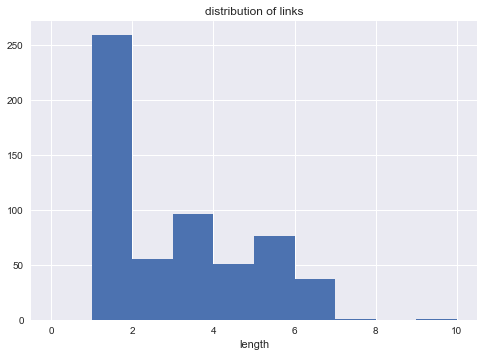

In [58]:
plt.title('distribution of links')
plt.xlabel('length')
print(Counter([i for l in links for i in l]))
plt.hist([i for l in links for i in l],np.arange(11),);

In [132]:
# pad with zeros, truncate longer than 6
X = pad_sequences(docs, dtype=float, truncating='post',padding='post')

# convert links 1,1,2 -> [1,0,0]
#                        [1,0,0]
#                        [0,1,0]
Y = np.array([to_categorical(np.array(y)-1, num_classes=10) for y in links])
Y_ind = [len(y) for y in Y]
Y = pad_sequences(Y, dtype=int, truncating='post', padding='post')

In [133]:
X.shape, Y.shape

((112, 10, 300), (112, 10, 10))

In [134]:
# X_train, Y_train = X[:96], Y[:96]
X_test, Y_test, Y_test_ind = X[100:], Y[100:], Y_ind[100:]

print(X_test.shape, Y_test.shape)

(12, 10, 300) (12, 10, 10)


In [225]:
def create_model(seq_len, hidden_size, dropout, masking):
    inp = Input(shape=(seq_len, 300), name='input')

    if masking:
        mask = Masking(mask_value=-1, input_shape=(seq_len, 300))(inp)
        encoder = Bidirectional(LSTM(hidden_size//2, return_sequences=True, name='encoder', recurrent_dropout=dropout, dropout=dropout))(mask)
        decoder = LSTM(hidden_size, return_sequences=True, name='decoder', recurrent_dropout=dropout, dropout=dropout)(encoder)
    else:        
        encoder = Bidirectional(LSTM(hidden_size//2, return_sequences=True, name='encoder', recurrent_dropout=dropout, dropout=dropout))(inp)
        decoder = LSTM(hidden_size, return_sequences=True, name='decoder', recurrent_dropout=dropout, dropout=dropout)(encoder)

    # glorot_uniform initializer:
    # uniform([-limit,limit]) where limit = sqrt(6/(in+out))
    # for hidden=512: uniform(-0.07, +0.07)
    E = TimeDistributed(Dense(hidden_size, use_bias=False, kernel_regularizer='l2'), name='E')(encoder)
    D = TimeDistributed(Dense(hidden_size, use_bias=False, kernel_regularizer='l2'), name='D')(decoder)

    DD = Lambda(lambda x: K.repeat_elements(K.expand_dims(x, 2), seq_len, 2))(D)

    add = Add(name='W1E_W2Di')
    tanh = Activation('tanh', name='tanh')

    # glorot_uniform initializer:
    # uniform([-limit,limit]) where limit = sqrt(6/(in+out))
    # for hidden=512: uniform(-0,108, +0,108)
    vt = Dense(1, use_bias=False, kernel_regularizer='l2', name='vT')
    softmax = Activation('softmax', name='softmax')

    attention = add([E,DD])
    attention = tanh(attention)
    attention = vt(attention)
    attention = Lambda(lambda x: K.squeeze(x, -1))(attention)
    attention = softmax(attention)

    model = Model(inputs=inp, outputs=attention)
    return model

In [228]:
model = create_model(seq_len=6, hidden_size=512, dropout=.9, masking=False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 6, 300)       0                                            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 6, 512)       1140736     input[0][0]                      
__________________________________________________________________________________________________
decoder (LSTM)                  (None, 6, 512)       2099200     bidirectional_10[0][0]           
__________________________________________________________________________________________________
D (TimeDistributed)             (None, 6, 512)       262144      decoder[0][0]                    
__________________________________________________________________________________________________
E (TimeDis

In [227]:
adam = Adam()
tensorboad = TensorBoard()

In [120]:
hidden_size = 512
seq_len = X.shape[1]
nb_epochs = 1000
batch_size = 10
dropout = .9

In [231]:
fixed_params = dict(hidden_size=512, seq_len=X.shape[1], nb_epoch=1000, batch_size=10, dropout=.9)

paramsearch = [
    dict(c_weights=False, padding=0, masking=False),
    dict(c_weights=False, padding=-1, masking=True),
    dict(c_weights=False, padding=-1, masking=False),
]

In [232]:
for param in paramsearch:
    param.update(fixed_params)

histories = []

for param in paramsearch:
    # pad with zeros, truncate longer than 6
    X = pad_sequences(docs, dtype=float, truncating='post',padding='post', value=param['padding'])

    # convert links 1,1,2 -> [1,0,0]
    #                        [1,0,0]
    #                        [0,1,0]
    Y = [pad_sequences(to_categorical(np.array(y)-1), truncating='post', padding='post', value=param['padding'],maxlen=10) for y in links]
    Y_ind = [len(y) for y in Y]
    Y = pad_sequences(Y, dtype=int, truncating='post', padding='post', value=param['padding'])
        
    histories.append([])
    kfold = ShuffleSplit(n_splits=5, test_size=20, random_state=seed)

    for train, val in tqdm(kfold.split(X[:100])):
        model = create_model(param['seq_len'], param['hidden_size'], param['dropout'], masking=param['masking'])
        model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'],
                      sample_weight_mode="temporal")  

        # class weights
        if param['c_weights']:
            class_num = Y.shape[-1]
            
            class_weights = dict(zip(np.arange(class_num),np.zeros(class_num)))
            labels = Y[train].argmax(2).flatten()
            un_labels = np.unique(labels)
            weights = class_weight.compute_class_weight('balanced', un_labels, labels)
            class_weights.update(zip(un_labels, weights))
            
            sample_weights = np.zeros(Y[train].shape[:2])
            for i in range(class_num):
                sample_weights[Y[train].argmax(2)==i] = class_weights[i]

        print(X[train].shape, X[val].shape)
        history = model.fit(X[train], Y[train], validation_data=(X[val], Y[val]),
                            epochs=param['nb_epoch'], batch_size=param['batch_size'], verbose=2)#, sample_weight=sample_weights)

        histories[-1].append(history)

        scores = model.evaluate(X[val], Y[val], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    # last validation accuracy
    val_acc = [h.history['val_categorical_accuracy'][-1] for h in histories]
    print("%.2f%% (+/- %.2f%%)" % (numpy.mean(val_acc), numpy.std(val_acc)))


0it [00:00, ?it/s]

(80, 10, 300) (20, 10, 300)


Train on 80 samples, validate on 20 samples
Epoch 1/1000
 - 7s - loss: 9.6923 - categorical_accuracy: 0.3788 - val_loss: 7.3163 - val_categorical_accuracy: 0.7450
Epoch 2/1000
 - 1s - loss: 5.6041 - categorical_accuracy: 0.6037 - val_loss: 4.0181 - val_categorical_accuracy: 0.7450
Epoch 3/1000
 - 1s - loss: 3.0093 - categorical_accuracy: 0.5800 - val_loss: 2.1488 - val_categorical_accuracy: 0.7250
Epoch 4/1000
 - 1s - loss: 1.7363 - categorical_accuracy: 0.5163 - val_loss: 1.4816 - val_categorical_accuracy: 0.7450
Epoch 5/1000
 - 1s - loss: 1.1484 - categorical_accuracy: 0.6162 - val_loss: 1.1223 - val_categorical_accuracy: 0.7300
Epoch 6/1000
 - 1s - loss: 0.9760 - categorical_accuracy: 0.5487 - val_loss: 1.0226 - val_categorical_accuracy: 0.7250
Epoch 7/1000
 - 1s - loss: 0.9175 - categorical_accuracy: 0.6000 - val_loss: 0.9818 - val_categorical_accuracy: 0.7250
Epoch 8/1000
 - 1s - loss: 0.8485 - categorical_accuracy: 0.5550 - val_loss: 0.8573 - val_categorical_accuracy: 0.6500
Epoc

Epoch 69/1000
 - 1s - loss: 0.5903 - categorical_accuracy: 0.6188 - val_loss: 0.6540 - val_categorical_accuracy: 0.5000
Epoch 70/1000
 - 1s - loss: 0.6058 - categorical_accuracy: 0.6112 - val_loss: 0.6700 - val_categorical_accuracy: 0.6000
Epoch 71/1000
 - 1s - loss: 0.5868 - categorical_accuracy: 0.5862 - val_loss: 0.6815 - val_categorical_accuracy: 0.6550
Epoch 72/1000
 - 1s - loss: 0.5906 - categorical_accuracy: 0.6013 - val_loss: 0.6415 - val_categorical_accuracy: 0.6250
Epoch 73/1000
 - 1s - loss: 0.6147 - categorical_accuracy: 0.6163 - val_loss: 0.6374 - val_categorical_accuracy: 0.6250
Epoch 74/1000
 - 1s - loss: 0.6035 - categorical_accuracy: 0.6075 - val_loss: 0.6422 - val_categorical_accuracy: 0.6650
Epoch 75/1000
 - 1s - loss: 0.5819 - categorical_accuracy: 0.6388 - val_loss: 0.6522 - val_categorical_accuracy: 0.6550
Epoch 76/1000
 - 1s - loss: 0.5954 - categorical_accuracy: 0.6062 - val_loss: 0.6685 - val_categorical_accuracy: 0.6550
Epoch 77/1000
 - 1s - loss: 0.5828 - cat

Epoch 137/1000
 - 1s - loss: 0.5174 - categorical_accuracy: 0.6375 - val_loss: 0.6260 - val_categorical_accuracy: 0.5650
Epoch 138/1000
 - 1s - loss: 0.5121 - categorical_accuracy: 0.6337 - val_loss: 0.6679 - val_categorical_accuracy: 0.6550
Epoch 139/1000
 - 1s - loss: 0.5180 - categorical_accuracy: 0.6575 - val_loss: 0.6743 - val_categorical_accuracy: 0.6550
Epoch 140/1000
 - 1s - loss: 0.5495 - categorical_accuracy: 0.6100 - val_loss: 0.6639 - val_categorical_accuracy: 0.6550
Epoch 141/1000
 - 1s - loss: 0.5527 - categorical_accuracy: 0.6087 - val_loss: 0.6466 - val_categorical_accuracy: 0.6550
Epoch 142/1000
 - 1s - loss: 0.5630 - categorical_accuracy: 0.5900 - val_loss: 0.6343 - val_categorical_accuracy: 0.5800
Epoch 143/1000
 - 1s - loss: 0.5831 - categorical_accuracy: 0.5825 - val_loss: 0.6429 - val_categorical_accuracy: 0.6800
Epoch 144/1000
 - 1s - loss: 0.5716 - categorical_accuracy: 0.6412 - val_loss: 0.6697 - val_categorical_accuracy: 0.6550
Epoch 145/1000
 - 1s - loss: 0.5

Epoch 205/1000
 - 1s - loss: 0.4609 - categorical_accuracy: 0.6612 - val_loss: 0.6679 - val_categorical_accuracy: 0.5900
Epoch 206/1000
 - 1s - loss: 0.5148 - categorical_accuracy: 0.6388 - val_loss: 0.6490 - val_categorical_accuracy: 0.5750
Epoch 207/1000
 - 1s - loss: 0.5455 - categorical_accuracy: 0.6075 - val_loss: 0.6448 - val_categorical_accuracy: 0.5900
Epoch 208/1000
 - 1s - loss: 0.5197 - categorical_accuracy: 0.6375 - val_loss: 0.6335 - val_categorical_accuracy: 0.6400
Epoch 209/1000
 - 1s - loss: 0.4921 - categorical_accuracy: 0.6400 - val_loss: 0.6602 - val_categorical_accuracy: 0.6150
Epoch 210/1000
 - 1s - loss: 0.4859 - categorical_accuracy: 0.6450 - val_loss: 0.6767 - val_categorical_accuracy: 0.5650
Epoch 211/1000
 - 1s - loss: 0.4857 - categorical_accuracy: 0.6425 - val_loss: 0.6526 - val_categorical_accuracy: 0.5450
Epoch 212/1000
 - 1s - loss: 0.4843 - categorical_accuracy: 0.6375 - val_loss: 0.6672 - val_categorical_accuracy: 0.5900
Epoch 213/1000
 - 1s - loss: 0.5

Epoch 273/1000
 - 1s - loss: 0.4710 - categorical_accuracy: 0.6213 - val_loss: 0.6442 - val_categorical_accuracy: 0.5800
Epoch 274/1000
 - 1s - loss: 0.4677 - categorical_accuracy: 0.6350 - val_loss: 0.6476 - val_categorical_accuracy: 0.5900
Epoch 275/1000
 - 1s - loss: 0.5167 - categorical_accuracy: 0.6412 - val_loss: 0.6314 - val_categorical_accuracy: 0.5800
Epoch 276/1000
 - 1s - loss: 0.4816 - categorical_accuracy: 0.6850 - val_loss: 0.6381 - val_categorical_accuracy: 0.5800
Epoch 277/1000
 - 1s - loss: 0.4739 - categorical_accuracy: 0.6463 - val_loss: 0.6477 - val_categorical_accuracy: 0.5500
Epoch 278/1000
 - 1s - loss: 0.4815 - categorical_accuracy: 0.6475 - val_loss: 0.6552 - val_categorical_accuracy: 0.5600
Epoch 279/1000
 - 1s - loss: 0.4677 - categorical_accuracy: 0.6225 - val_loss: 0.6639 - val_categorical_accuracy: 0.5600
Epoch 280/1000
 - 1s - loss: 0.4836 - categorical_accuracy: 0.6388 - val_loss: 0.6634 - val_categorical_accuracy: 0.5900
Epoch 281/1000
 - 1s - loss: 0.5

Epoch 341/1000
 - 1s - loss: 0.4618 - categorical_accuracy: 0.6225 - val_loss: 0.6364 - val_categorical_accuracy: 0.5650
Epoch 342/1000
 - 1s - loss: 0.4681 - categorical_accuracy: 0.6437 - val_loss: 0.6317 - val_categorical_accuracy: 0.5650
Epoch 343/1000
 - 1s - loss: 0.4599 - categorical_accuracy: 0.6613 - val_loss: 0.6469 - val_categorical_accuracy: 0.5750
Epoch 344/1000
 - 1s - loss: 0.4608 - categorical_accuracy: 0.6388 - val_loss: 0.6651 - val_categorical_accuracy: 0.5450
Epoch 345/1000
 - 1s - loss: 0.4607 - categorical_accuracy: 0.6250 - val_loss: 0.6616 - val_categorical_accuracy: 0.5900
Epoch 346/1000
 - 1s - loss: 0.4706 - categorical_accuracy: 0.6412 - val_loss: 0.6368 - val_categorical_accuracy: 0.5800
Epoch 347/1000
 - 1s - loss: 0.4432 - categorical_accuracy: 0.6200 - val_loss: 0.6515 - val_categorical_accuracy: 0.5900
Epoch 348/1000
 - 1s - loss: 0.4680 - categorical_accuracy: 0.6525 - val_loss: 0.6701 - val_categorical_accuracy: 0.5900
Epoch 349/1000
 - 1s - loss: 0.4

Epoch 409/1000
 - 1s - loss: 0.4513 - categorical_accuracy: 0.6600 - val_loss: 0.6410 - val_categorical_accuracy: 0.5750
Epoch 410/1000
 - 1s - loss: 0.4402 - categorical_accuracy: 0.6375 - val_loss: 0.6508 - val_categorical_accuracy: 0.5750
Epoch 411/1000
 - 1s - loss: 0.4462 - categorical_accuracy: 0.6425 - val_loss: 0.6580 - val_categorical_accuracy: 0.5750
Epoch 412/1000
 - 1s - loss: 0.4646 - categorical_accuracy: 0.6337 - val_loss: 0.6537 - val_categorical_accuracy: 0.5750
Epoch 413/1000
 - 1s - loss: 0.4287 - categorical_accuracy: 0.6625 - val_loss: 0.6658 - val_categorical_accuracy: 0.5900
Epoch 414/1000
 - 2s - loss: 0.4580 - categorical_accuracy: 0.6637 - val_loss: 0.6530 - val_categorical_accuracy: 0.5750
Epoch 415/1000
 - 1s - loss: 0.4436 - categorical_accuracy: 0.6362 - val_loss: 0.6541 - val_categorical_accuracy: 0.5500
Epoch 416/1000
 - 1s - loss: 0.4475 - categorical_accuracy: 0.6350 - val_loss: 0.6630 - val_categorical_accuracy: 0.5900
Epoch 417/1000
 - 1s - loss: 0.4

Epoch 477/1000
 - 1s - loss: 0.4150 - categorical_accuracy: 0.6600 - val_loss: 0.6454 - val_categorical_accuracy: 0.5500
Epoch 478/1000
 - 1s - loss: 0.4330 - categorical_accuracy: 0.6250 - val_loss: 0.6548 - val_categorical_accuracy: 0.5750
Epoch 479/1000
 - 1s - loss: 0.4931 - categorical_accuracy: 0.6525 - val_loss: 0.6393 - val_categorical_accuracy: 0.5900
Epoch 480/1000
 - 1s - loss: 0.4370 - categorical_accuracy: 0.6600 - val_loss: 0.6343 - val_categorical_accuracy: 0.5500
Epoch 481/1000
 - 1s - loss: 0.4336 - categorical_accuracy: 0.6425 - val_loss: 0.6637 - val_categorical_accuracy: 0.5900
Epoch 482/1000
 - 1s - loss: 0.4301 - categorical_accuracy: 0.6662 - val_loss: 0.6727 - val_categorical_accuracy: 0.5900
Epoch 483/1000
 - 1s - loss: 0.4272 - categorical_accuracy: 0.6700 - val_loss: 0.6598 - val_categorical_accuracy: 0.5750
Epoch 484/1000
 - 1s - loss: 0.4165 - categorical_accuracy: 0.6700 - val_loss: 0.6499 - val_categorical_accuracy: 0.4800
Epoch 485/1000
 - 1s - loss: 0.4

Epoch 545/1000
 - 1s - loss: 0.4213 - categorical_accuracy: 0.6412 - val_loss: 0.6370 - val_categorical_accuracy: 0.5750
Epoch 546/1000
 - 1s - loss: 0.4218 - categorical_accuracy: 0.6587 - val_loss: 0.6320 - val_categorical_accuracy: 0.5750
Epoch 547/1000
 - 1s - loss: 0.4002 - categorical_accuracy: 0.6687 - val_loss: 0.6398 - val_categorical_accuracy: 0.5750
Epoch 548/1000
 - 1s - loss: 0.4346 - categorical_accuracy: 0.6537 - val_loss: 0.6498 - val_categorical_accuracy: 0.5750
Epoch 549/1000
 - 1s - loss: 0.4217 - categorical_accuracy: 0.6600 - val_loss: 0.6475 - val_categorical_accuracy: 0.5750
Epoch 550/1000
 - 1s - loss: 0.4321 - categorical_accuracy: 0.6400 - val_loss: 0.6406 - val_categorical_accuracy: 0.5750
Epoch 551/1000
 - 1s - loss: 0.4265 - categorical_accuracy: 0.6650 - val_loss: 0.6408 - val_categorical_accuracy: 0.5750
Epoch 552/1000
 - 1s - loss: 0.4335 - categorical_accuracy: 0.6650 - val_loss: 0.6376 - val_categorical_accuracy: 0.5750
Epoch 553/1000
 - 1s - loss: 0.4

Epoch 613/1000
 - 1s - loss: 0.4201 - categorical_accuracy: 0.6500 - val_loss: 0.6409 - val_categorical_accuracy: 0.5900
Epoch 614/1000
 - 1s - loss: 0.4157 - categorical_accuracy: 0.6588 - val_loss: 0.6395 - val_categorical_accuracy: 0.5850
Epoch 615/1000
 - 1s - loss: 0.4424 - categorical_accuracy: 0.6325 - val_loss: 0.6355 - val_categorical_accuracy: 0.5900
Epoch 616/1000
 - 1s - loss: 0.4247 - categorical_accuracy: 0.6250 - val_loss: 0.6424 - val_categorical_accuracy: 0.5750
Epoch 617/1000
 - 1s - loss: 0.3921 - categorical_accuracy: 0.6812 - val_loss: 0.6397 - val_categorical_accuracy: 0.5750
Epoch 618/1000
 - 1s - loss: 0.4119 - categorical_accuracy: 0.6675 - val_loss: 0.6383 - val_categorical_accuracy: 0.5500
Epoch 619/1000
 - 1s - loss: 0.4496 - categorical_accuracy: 0.6375 - val_loss: 0.6424 - val_categorical_accuracy: 0.5650
Epoch 620/1000
 - 1s - loss: 0.4060 - categorical_accuracy: 0.6550 - val_loss: 0.6364 - val_categorical_accuracy: 0.5650
Epoch 621/1000
 - 1s - loss: 0.4

Epoch 681/1000
 - 1s - loss: 0.3970 - categorical_accuracy: 0.6675 - val_loss: 0.6551 - val_categorical_accuracy: 0.5750
Epoch 682/1000
 - 1s - loss: 0.3980 - categorical_accuracy: 0.6513 - val_loss: 0.6583 - val_categorical_accuracy: 0.5100
Epoch 683/1000
 - 1s - loss: 0.4047 - categorical_accuracy: 0.6425 - val_loss: 0.6568 - val_categorical_accuracy: 0.5300
Epoch 684/1000
 - 1s - loss: 0.3815 - categorical_accuracy: 0.6750 - val_loss: 0.6561 - val_categorical_accuracy: 0.5200
Epoch 685/1000
 - 1s - loss: 0.3827 - categorical_accuracy: 0.6275 - val_loss: 0.6632 - val_categorical_accuracy: 0.5250
Epoch 686/1000
 - 1s - loss: 0.3954 - categorical_accuracy: 0.6500 - val_loss: 0.6693 - val_categorical_accuracy: 0.5900
Epoch 687/1000
 - 1s - loss: 0.3873 - categorical_accuracy: 0.6612 - val_loss: 0.6561 - val_categorical_accuracy: 0.5900
Epoch 688/1000
 - 1s - loss: 0.4057 - categorical_accuracy: 0.6550 - val_loss: 0.6487 - val_categorical_accuracy: 0.5900
Epoch 689/1000
 - 1s - loss: 0.3

Epoch 749/1000
 - 1s - loss: 0.3936 - categorical_accuracy: 0.6650 - val_loss: 0.6529 - val_categorical_accuracy: 0.5750
Epoch 750/1000
 - 1s - loss: 0.4018 - categorical_accuracy: 0.6650 - val_loss: 0.6378 - val_categorical_accuracy: 0.5750
Epoch 751/1000
 - 1s - loss: 0.3950 - categorical_accuracy: 0.6425 - val_loss: 0.6312 - val_categorical_accuracy: 0.5900
Epoch 752/1000
 - 1s - loss: 0.4029 - categorical_accuracy: 0.6787 - val_loss: 0.6331 - val_categorical_accuracy: 0.5900
Epoch 753/1000
 - 1s - loss: 0.4024 - categorical_accuracy: 0.6688 - val_loss: 0.6335 - val_categorical_accuracy: 0.5900
Epoch 754/1000
 - 1s - loss: 0.3871 - categorical_accuracy: 0.6575 - val_loss: 0.6409 - val_categorical_accuracy: 0.5650
Epoch 755/1000
 - 1s - loss: 0.3971 - categorical_accuracy: 0.6725 - val_loss: 0.6497 - val_categorical_accuracy: 0.5650
Epoch 756/1000
 - 1s - loss: 0.4077 - categorical_accuracy: 0.6400 - val_loss: 0.6523 - val_categorical_accuracy: 0.5650
Epoch 757/1000
 - 1s - loss: 0.3

Epoch 817/1000
 - 2s - loss: 0.3985 - categorical_accuracy: 0.6812 - val_loss: 0.6677 - val_categorical_accuracy: 0.5000
Epoch 818/1000
 - 1s - loss: 0.3800 - categorical_accuracy: 0.6400 - val_loss: 0.6703 - val_categorical_accuracy: 0.5800
Epoch 819/1000
 - 1s - loss: 0.3537 - categorical_accuracy: 0.6800 - val_loss: 0.6575 - val_categorical_accuracy: 0.5900
Epoch 820/1000
 - 1s - loss: 0.4017 - categorical_accuracy: 0.6713 - val_loss: 0.6445 - val_categorical_accuracy: 0.5900
Epoch 821/1000
 - 2s - loss: 0.3842 - categorical_accuracy: 0.6625 - val_loss: 0.6522 - val_categorical_accuracy: 0.5900
Epoch 822/1000
 - 2s - loss: 0.3701 - categorical_accuracy: 0.6775 - val_loss: 0.6630 - val_categorical_accuracy: 0.5650
Epoch 823/1000
 - 1s - loss: 0.3766 - categorical_accuracy: 0.6687 - val_loss: 0.6520 - val_categorical_accuracy: 0.5900
Epoch 824/1000
 - 1s - loss: 0.3673 - categorical_accuracy: 0.6725 - val_loss: 0.6408 - val_categorical_accuracy: 0.5900
Epoch 825/1000
 - 1s - loss: 0.3

Epoch 885/1000
 - 2s - loss: 0.3858 - categorical_accuracy: 0.6687 - val_loss: 0.6705 - val_categorical_accuracy: 0.5900
Epoch 886/1000
 - 1s - loss: 0.3812 - categorical_accuracy: 0.6638 - val_loss: 0.6634 - val_categorical_accuracy: 0.5200
Epoch 887/1000
 - 2s - loss: 0.3790 - categorical_accuracy: 0.6725 - val_loss: 0.6741 - val_categorical_accuracy: 0.5500
Epoch 888/1000
 - 2s - loss: 0.3883 - categorical_accuracy: 0.6712 - val_loss: 0.6652 - val_categorical_accuracy: 0.5350
Epoch 889/1000
 - 1s - loss: 0.3966 - categorical_accuracy: 0.6850 - val_loss: 0.6640 - val_categorical_accuracy: 0.4800
Epoch 890/1000
 - 2s - loss: 0.3696 - categorical_accuracy: 0.6713 - val_loss: 0.6722 - val_categorical_accuracy: 0.5100
Epoch 891/1000
 - 2s - loss: 0.3646 - categorical_accuracy: 0.6750 - val_loss: 0.6731 - val_categorical_accuracy: 0.5250
Epoch 892/1000
 - 1s - loss: 0.4028 - categorical_accuracy: 0.6513 - val_loss: 0.6795 - val_categorical_accuracy: 0.5200
Epoch 893/1000
 - 1s - loss: 0.4

Epoch 953/1000
 - 1s - loss: 0.3764 - categorical_accuracy: 0.6687 - val_loss: 0.6764 - val_categorical_accuracy: 0.5250
Epoch 954/1000
 - 1s - loss: 0.3742 - categorical_accuracy: 0.6675 - val_loss: 0.6780 - val_categorical_accuracy: 0.5500
Epoch 955/1000
 - 1s - loss: 0.3867 - categorical_accuracy: 0.6750 - val_loss: 0.6727 - val_categorical_accuracy: 0.5450
Epoch 956/1000
 - 1s - loss: 0.3968 - categorical_accuracy: 0.6325 - val_loss: 0.6715 - val_categorical_accuracy: 0.5350
Epoch 957/1000
 - 1s - loss: 0.3632 - categorical_accuracy: 0.6700 - val_loss: 0.6791 - val_categorical_accuracy: 0.5450
Epoch 958/1000
 - 1s - loss: 0.3727 - categorical_accuracy: 0.6625 - val_loss: 0.6879 - val_categorical_accuracy: 0.5500
Epoch 959/1000
 - 1s - loss: 0.3775 - categorical_accuracy: 0.6800 - val_loss: 0.6760 - val_categorical_accuracy: 0.4950
Epoch 960/1000
 - 1s - loss: 0.3812 - categorical_accuracy: 0.6438 - val_loss: 0.6762 - val_categorical_accuracy: 0.4950
Epoch 961/1000
 - 1s - loss: 0.3

1it [22:02, 1322.50s/it]

categorical_accuracy: 48.00%
(80, 10, 300) (20, 10, 300)
Train on 80 samples, validate on 20 samples
Epoch 1/1000
 - 9s - loss: 7.0663 - categorical_accuracy: 0.4313 - val_loss: 2.6973 - val_categorical_accuracy: 0.6100
Epoch 2/1000
 - 1s - loss: 1.7525 - categorical_accuracy: 0.4863 - val_loss: 1.6536 - val_categorical_accuracy: 0.5950
Epoch 3/1000
 - 2s - loss: 1.4473 - categorical_accuracy: 0.5300 - val_loss: 1.4854 - val_categorical_accuracy: 0.5650
Epoch 4/1000
 - 1s - loss: 1.1694 - categorical_accuracy: 0.6300 - val_loss: 1.2275 - val_categorical_accuracy: 0.5800
Epoch 5/1000
 - 1s - loss: 0.8831 - categorical_accuracy: 0.6113 - val_loss: 1.0214 - val_categorical_accuracy: 0.5600
Epoch 6/1000
 - 1s - loss: 0.8246 - categorical_accuracy: 0.5475 - val_loss: 1.0605 - val_categorical_accuracy: 0.5600
Epoch 7/1000
 - 1s - loss: 0.7988 - categorical_accuracy: 0.6013 - val_loss: 1.0034 - val_categorical_accuracy: 0.5600
Epoch 8/1000
 - 1s - loss: 0.7460 - categorical_accuracy: 0.5437 -

Epoch 69/1000
 - 1s - loss: 0.5755 - categorical_accuracy: 0.6550 - val_loss: 0.8745 - val_categorical_accuracy: 0.5500
Epoch 70/1000
 - 1s - loss: 0.5449 - categorical_accuracy: 0.6462 - val_loss: 0.8792 - val_categorical_accuracy: 0.5500
Epoch 71/1000
 - 1s - loss: 0.5163 - categorical_accuracy: 0.6575 - val_loss: 0.8901 - val_categorical_accuracy: 0.5500
Epoch 72/1000
 - 1s - loss: 0.5186 - categorical_accuracy: 0.6612 - val_loss: 0.8863 - val_categorical_accuracy: 0.5500
Epoch 73/1000
 - 1s - loss: 0.5323 - categorical_accuracy: 0.6462 - val_loss: 0.8572 - val_categorical_accuracy: 0.5200
Epoch 74/1000
 - 1s - loss: 0.5086 - categorical_accuracy: 0.6212 - val_loss: 0.8649 - val_categorical_accuracy: 0.5500
Epoch 75/1000
 - 1s - loss: 0.5479 - categorical_accuracy: 0.5950 - val_loss: 0.9112 - val_categorical_accuracy: 0.5500
Epoch 76/1000
 - 1s - loss: 0.5332 - categorical_accuracy: 0.6775 - val_loss: 0.9151 - val_categorical_accuracy: 0.5550
Epoch 77/1000
 - 1s - loss: 0.5230 - cat

Epoch 137/1000
 - 2s - loss: 0.4924 - categorical_accuracy: 0.6925 - val_loss: 0.9058 - val_categorical_accuracy: 0.5550
Epoch 138/1000
 - 1s - loss: 0.5087 - categorical_accuracy: 0.6425 - val_loss: 0.9042 - val_categorical_accuracy: 0.5450
Epoch 139/1000
 - 1s - loss: 0.4749 - categorical_accuracy: 0.6975 - val_loss: 0.9139 - val_categorical_accuracy: 0.5450
Epoch 140/1000
 - 1s - loss: 0.5184 - categorical_accuracy: 0.6475 - val_loss: 0.8964 - val_categorical_accuracy: 0.5400
Epoch 141/1000
 - 1s - loss: 0.4848 - categorical_accuracy: 0.6700 - val_loss: 0.8996 - val_categorical_accuracy: 0.5400
Epoch 142/1000
 - 1s - loss: 0.5024 - categorical_accuracy: 0.6612 - val_loss: 0.8766 - val_categorical_accuracy: 0.5200
Epoch 143/1000
 - 1s - loss: 0.4805 - categorical_accuracy: 0.6763 - val_loss: 0.8979 - val_categorical_accuracy: 0.5400
Epoch 144/1000
 - 1s - loss: 0.4848 - categorical_accuracy: 0.6312 - val_loss: 0.9152 - val_categorical_accuracy: 0.5450
Epoch 145/1000
 - 1s - loss: 0.4

Epoch 205/1000
 - 1s - loss: 0.4478 - categorical_accuracy: 0.6737 - val_loss: 0.8993 - val_categorical_accuracy: 0.5550
Epoch 206/1000
 - 1s - loss: 0.4636 - categorical_accuracy: 0.6487 - val_loss: 0.9459 - val_categorical_accuracy: 0.5450
Epoch 207/1000
 - 1s - loss: 0.4507 - categorical_accuracy: 0.6912 - val_loss: 0.9310 - val_categorical_accuracy: 0.5450
Epoch 208/1000
 - 1s - loss: 0.4678 - categorical_accuracy: 0.6588 - val_loss: 0.8807 - val_categorical_accuracy: 0.5450
Epoch 209/1000
 - 1s - loss: 0.4563 - categorical_accuracy: 0.6863 - val_loss: 0.9132 - val_categorical_accuracy: 0.5450
Epoch 210/1000
 - 1s - loss: 0.4599 - categorical_accuracy: 0.7075 - val_loss: 0.9293 - val_categorical_accuracy: 0.5450
Epoch 211/1000
 - 1s - loss: 0.4454 - categorical_accuracy: 0.6912 - val_loss: 0.8886 - val_categorical_accuracy: 0.5450
Epoch 212/1000
 - 1s - loss: 0.4653 - categorical_accuracy: 0.6725 - val_loss: 0.9192 - val_categorical_accuracy: 0.5450
Epoch 213/1000
 - 1s - loss: 0.4

Epoch 273/1000
 - 1s - loss: 0.4316 - categorical_accuracy: 0.6788 - val_loss: 0.9693 - val_categorical_accuracy: 0.5450
Epoch 274/1000
 - 1s - loss: 0.4384 - categorical_accuracy: 0.6863 - val_loss: 0.9241 - val_categorical_accuracy: 0.5450
Epoch 275/1000
 - 1s - loss: 0.4466 - categorical_accuracy: 0.6512 - val_loss: 0.8840 - val_categorical_accuracy: 0.5450
Epoch 276/1000
 - 1s - loss: 0.4391 - categorical_accuracy: 0.6613 - val_loss: 0.9152 - val_categorical_accuracy: 0.5450
Epoch 277/1000
 - 1s - loss: 0.4421 - categorical_accuracy: 0.6788 - val_loss: 0.9367 - val_categorical_accuracy: 0.5450
Epoch 278/1000
 - 1s - loss: 0.4612 - categorical_accuracy: 0.6488 - val_loss: 0.8947 - val_categorical_accuracy: 0.5450
Epoch 279/1000
 - 1s - loss: 0.4349 - categorical_accuracy: 0.6850 - val_loss: 0.9498 - val_categorical_accuracy: 0.5600
Epoch 280/1000
 - 1s - loss: 0.4598 - categorical_accuracy: 0.7125 - val_loss: 0.9387 - val_categorical_accuracy: 0.5600
Epoch 281/1000
 - 1s - loss: 0.4

Epoch 341/1000
 - 1s - loss: 0.4189 - categorical_accuracy: 0.6725 - val_loss: 0.9224 - val_categorical_accuracy: 0.5200
Epoch 342/1000
 - 1s - loss: 0.4253 - categorical_accuracy: 0.6625 - val_loss: 0.9147 - val_categorical_accuracy: 0.5300
Epoch 343/1000
 - 1s - loss: 0.4079 - categorical_accuracy: 0.6987 - val_loss: 0.9581 - val_categorical_accuracy: 0.5200
Epoch 344/1000
 - 1s - loss: 0.4269 - categorical_accuracy: 0.6962 - val_loss: 0.9294 - val_categorical_accuracy: 0.5300
Epoch 345/1000
 - 1s - loss: 0.4322 - categorical_accuracy: 0.6625 - val_loss: 0.9245 - val_categorical_accuracy: 0.5350
Epoch 346/1000
 - 1s - loss: 0.4066 - categorical_accuracy: 0.6738 - val_loss: 0.9250 - val_categorical_accuracy: 0.5250
Epoch 347/1000
 - 1s - loss: 0.4415 - categorical_accuracy: 0.7175 - val_loss: 0.9002 - val_categorical_accuracy: 0.5350
Epoch 348/1000
 - 1s - loss: 0.4351 - categorical_accuracy: 0.6662 - val_loss: 0.8943 - val_categorical_accuracy: 0.5050
Epoch 349/1000
 - 1s - loss: 0.4

Epoch 409/1000
 - 1s - loss: 0.3841 - categorical_accuracy: 0.6975 - val_loss: 0.9325 - val_categorical_accuracy: 0.5250
Epoch 410/1000
 - 1s - loss: 0.4217 - categorical_accuracy: 0.6900 - val_loss: 0.9303 - val_categorical_accuracy: 0.5200
Epoch 411/1000
 - 1s - loss: 0.4147 - categorical_accuracy: 0.6763 - val_loss: 0.9276 - val_categorical_accuracy: 0.5200
Epoch 412/1000
 - 1s - loss: 0.4193 - categorical_accuracy: 0.6637 - val_loss: 0.9493 - val_categorical_accuracy: 0.5200
Epoch 413/1000
 - 1s - loss: 0.4086 - categorical_accuracy: 0.6950 - val_loss: 0.9354 - val_categorical_accuracy: 0.5200
Epoch 414/1000
 - 1s - loss: 0.4234 - categorical_accuracy: 0.6900 - val_loss: 0.9567 - val_categorical_accuracy: 0.5200
Epoch 415/1000
 - 1s - loss: 0.3969 - categorical_accuracy: 0.7000 - val_loss: 0.9431 - val_categorical_accuracy: 0.5200
Epoch 416/1000
 - 1s - loss: 0.4062 - categorical_accuracy: 0.6913 - val_loss: 0.9449 - val_categorical_accuracy: 0.5200
Epoch 417/1000
 - 1s - loss: 0.4

Epoch 477/1000
 - 1s - loss: 0.3946 - categorical_accuracy: 0.7075 - val_loss: 0.9513 - val_categorical_accuracy: 0.5250
Epoch 478/1000
 - 1s - loss: 0.4139 - categorical_accuracy: 0.6412 - val_loss: 0.9369 - val_categorical_accuracy: 0.5250
Epoch 479/1000
 - 1s - loss: 0.4061 - categorical_accuracy: 0.6762 - val_loss: 0.9050 - val_categorical_accuracy: 0.5250
Epoch 480/1000
 - 1s - loss: 0.4054 - categorical_accuracy: 0.6950 - val_loss: 0.9212 - val_categorical_accuracy: 0.5250
Epoch 481/1000
 - 1s - loss: 0.3845 - categorical_accuracy: 0.6763 - val_loss: 0.9539 - val_categorical_accuracy: 0.5250
Epoch 482/1000
 - 1s - loss: 0.4038 - categorical_accuracy: 0.6450 - val_loss: 0.9433 - val_categorical_accuracy: 0.5250
Epoch 483/1000
 - 1s - loss: 0.4024 - categorical_accuracy: 0.6913 - val_loss: 0.9577 - val_categorical_accuracy: 0.5250
Epoch 484/1000
 - 1s - loss: 0.4079 - categorical_accuracy: 0.6800 - val_loss: 0.9805 - val_categorical_accuracy: 0.5250
Epoch 485/1000
 - 1s - loss: 0.4

Epoch 545/1000
 - 1s - loss: 0.4057 - categorical_accuracy: 0.6863 - val_loss: 0.9174 - val_categorical_accuracy: 0.5200
Epoch 546/1000
 - 1s - loss: 0.4087 - categorical_accuracy: 0.6500 - val_loss: 0.9495 - val_categorical_accuracy: 0.5200
Epoch 547/1000
 - 1s - loss: 0.3979 - categorical_accuracy: 0.7125 - val_loss: 0.9472 - val_categorical_accuracy: 0.5500
Epoch 548/1000
 - 1s - loss: 0.4025 - categorical_accuracy: 0.6738 - val_loss: 0.9536 - val_categorical_accuracy: 0.5500
Epoch 549/1000
 - 1s - loss: 0.3850 - categorical_accuracy: 0.7112 - val_loss: 0.9532 - val_categorical_accuracy: 0.5300
Epoch 550/1000
 - 1s - loss: 0.4119 - categorical_accuracy: 0.6763 - val_loss: 0.9763 - val_categorical_accuracy: 0.5500
Epoch 551/1000
 - 1s - loss: 0.3842 - categorical_accuracy: 0.6875 - val_loss: 0.9570 - val_categorical_accuracy: 0.5500
Epoch 552/1000
 - 1s - loss: 0.3832 - categorical_accuracy: 0.7000 - val_loss: 0.9541 - val_categorical_accuracy: 0.5500
Epoch 553/1000
 - 1s - loss: 0.3

Epoch 613/1000
 - 1s - loss: 0.3829 - categorical_accuracy: 0.6888 - val_loss: 0.9470 - val_categorical_accuracy: 0.5650
Epoch 614/1000
 - 1s - loss: 0.3893 - categorical_accuracy: 0.6900 - val_loss: 0.9313 - val_categorical_accuracy: 0.5650
Epoch 615/1000
 - 1s - loss: 0.3755 - categorical_accuracy: 0.6900 - val_loss: 0.9159 - val_categorical_accuracy: 0.5500
Epoch 616/1000
 - 1s - loss: 0.4051 - categorical_accuracy: 0.6413 - val_loss: 0.9260 - val_categorical_accuracy: 0.5500
Epoch 617/1000
 - 1s - loss: 0.4135 - categorical_accuracy: 0.6487 - val_loss: 0.9340 - val_categorical_accuracy: 0.5650
Epoch 618/1000
 - 1s - loss: 0.4032 - categorical_accuracy: 0.6938 - val_loss: 0.9297 - val_categorical_accuracy: 0.5650
Epoch 619/1000
 - 1s - loss: 0.3643 - categorical_accuracy: 0.7125 - val_loss: 0.9368 - val_categorical_accuracy: 0.5500
Epoch 620/1000
 - 1s - loss: 0.3977 - categorical_accuracy: 0.6987 - val_loss: 0.9276 - val_categorical_accuracy: 0.5500
Epoch 621/1000
 - 1s - loss: 0.3

Epoch 681/1000
 - 1s - loss: 0.3977 - categorical_accuracy: 0.6587 - val_loss: 0.9109 - val_categorical_accuracy: 0.5650
Epoch 682/1000
 - 1s - loss: 0.3997 - categorical_accuracy: 0.6587 - val_loss: 0.9143 - val_categorical_accuracy: 0.5650
Epoch 683/1000
 - 1s - loss: 0.3697 - categorical_accuracy: 0.7075 - val_loss: 0.9286 - val_categorical_accuracy: 0.5650
Epoch 684/1000
 - 1s - loss: 0.3627 - categorical_accuracy: 0.6912 - val_loss: 0.9455 - val_categorical_accuracy: 0.5650
Epoch 685/1000
 - 1s - loss: 0.3819 - categorical_accuracy: 0.6913 - val_loss: 0.9566 - val_categorical_accuracy: 0.5650
Epoch 686/1000
 - 1s - loss: 0.3590 - categorical_accuracy: 0.7038 - val_loss: 0.9582 - val_categorical_accuracy: 0.5650
Epoch 687/1000
 - 1s - loss: 0.3848 - categorical_accuracy: 0.6800 - val_loss: 0.9518 - val_categorical_accuracy: 0.5650
Epoch 688/1000
 - 1s - loss: 0.3883 - categorical_accuracy: 0.6812 - val_loss: 0.9465 - val_categorical_accuracy: 0.5650
Epoch 689/1000
 - 1s - loss: 0.3

Epoch 749/1000
 - 1s - loss: 0.3636 - categorical_accuracy: 0.7013 - val_loss: 0.9360 - val_categorical_accuracy: 0.5350
Epoch 750/1000
 - 1s - loss: 0.3816 - categorical_accuracy: 0.6775 - val_loss: 0.9437 - val_categorical_accuracy: 0.5150
Epoch 751/1000
 - 1s - loss: 0.3695 - categorical_accuracy: 0.6900 - val_loss: 0.9502 - val_categorical_accuracy: 0.5150
Epoch 752/1000
 - 1s - loss: 0.3823 - categorical_accuracy: 0.6887 - val_loss: 0.9898 - val_categorical_accuracy: 0.5650
Epoch 753/1000
 - 1s - loss: 0.3632 - categorical_accuracy: 0.6975 - val_loss: 0.9857 - val_categorical_accuracy: 0.5650
Epoch 754/1000
 - 1s - loss: 0.3503 - categorical_accuracy: 0.6812 - val_loss: 0.9631 - val_categorical_accuracy: 0.5650
Epoch 755/1000
 - 1s - loss: 0.3655 - categorical_accuracy: 0.6850 - val_loss: 0.9606 - val_categorical_accuracy: 0.5650
Epoch 756/1000
 - 1s - loss: 0.3700 - categorical_accuracy: 0.6638 - val_loss: 0.9749 - val_categorical_accuracy: 0.5600
Epoch 757/1000
 - 1s - loss: 0.3

Epoch 817/1000
 - 1s - loss: 0.3917 - categorical_accuracy: 0.6812 - val_loss: 0.9464 - val_categorical_accuracy: 0.5350
Epoch 818/1000
 - 1s - loss: 0.3849 - categorical_accuracy: 0.6675 - val_loss: 0.9767 - val_categorical_accuracy: 0.5350
Epoch 819/1000
 - 1s - loss: 0.3704 - categorical_accuracy: 0.6812 - val_loss: 0.9890 - val_categorical_accuracy: 0.5350
Epoch 820/1000
 - 1s - loss: 0.3761 - categorical_accuracy: 0.6713 - val_loss: 0.9884 - val_categorical_accuracy: 0.5350
Epoch 821/1000
 - 1s - loss: 0.3709 - categorical_accuracy: 0.7075 - val_loss: 0.9878 - val_categorical_accuracy: 0.5150
Epoch 822/1000
 - 1s - loss: 0.3628 - categorical_accuracy: 0.6837 - val_loss: 0.9791 - val_categorical_accuracy: 0.5350
Epoch 823/1000
 - 1s - loss: 0.3599 - categorical_accuracy: 0.6700 - val_loss: 0.9348 - val_categorical_accuracy: 0.5000
Epoch 824/1000
 - 1s - loss: 0.3653 - categorical_accuracy: 0.6438 - val_loss: 0.9457 - val_categorical_accuracy: 0.5350
Epoch 825/1000
 - 1s - loss: 0.3

Epoch 885/1000
 - 1s - loss: 0.3657 - categorical_accuracy: 0.7100 - val_loss: 0.9312 - val_categorical_accuracy: 0.5000
Epoch 886/1000
 - 1s - loss: 0.3801 - categorical_accuracy: 0.6838 - val_loss: 0.9378 - val_categorical_accuracy: 0.5100
Epoch 887/1000
 - 1s - loss: 0.3813 - categorical_accuracy: 0.6375 - val_loss: 0.9840 - val_categorical_accuracy: 0.5350
Epoch 888/1000
 - 1s - loss: 0.3488 - categorical_accuracy: 0.6925 - val_loss: 0.9849 - val_categorical_accuracy: 0.5350
Epoch 889/1000
 - 1s - loss: 0.3706 - categorical_accuracy: 0.7013 - val_loss: 0.9661 - val_categorical_accuracy: 0.5350
Epoch 890/1000
 - 1s - loss: 0.3476 - categorical_accuracy: 0.6988 - val_loss: 0.9389 - val_categorical_accuracy: 0.5400
Epoch 891/1000
 - 1s - loss: 0.3390 - categorical_accuracy: 0.7137 - val_loss: 0.9480 - val_categorical_accuracy: 0.5350
Epoch 892/1000
 - 1s - loss: 0.3756 - categorical_accuracy: 0.6900 - val_loss: 0.9359 - val_categorical_accuracy: 0.5350
Epoch 893/1000
 - 1s - loss: 0.3

Epoch 953/1000
 - 1s - loss: 0.3358 - categorical_accuracy: 0.6875 - val_loss: 0.9437 - val_categorical_accuracy: 0.5150
Epoch 954/1000
 - 1s - loss: 0.3592 - categorical_accuracy: 0.6788 - val_loss: 0.9555 - val_categorical_accuracy: 0.5350
Epoch 955/1000
 - 1s - loss: 0.3762 - categorical_accuracy: 0.6788 - val_loss: 0.9852 - val_categorical_accuracy: 0.5350
Epoch 956/1000
 - 1s - loss: 0.3837 - categorical_accuracy: 0.6688 - val_loss: 0.9795 - val_categorical_accuracy: 0.5350
Epoch 957/1000
 - 1s - loss: 0.3691 - categorical_accuracy: 0.7075 - val_loss: 0.9796 - val_categorical_accuracy: 0.5350
Epoch 958/1000
 - 1s - loss: 0.3640 - categorical_accuracy: 0.6837 - val_loss: 0.9662 - val_categorical_accuracy: 0.5350
Epoch 959/1000
 - 1s - loss: 0.3367 - categorical_accuracy: 0.7138 - val_loss: 0.9611 - val_categorical_accuracy: 0.5350
Epoch 960/1000
 - 1s - loss: 0.3823 - categorical_accuracy: 0.6813 - val_loss: 0.9380 - val_categorical_accuracy: 0.5350
Epoch 961/1000
 - 1s - loss: 0.3

2it [44:07, 1323.25s/it]

categorical_accuracy: 53.50%
(80, 10, 300) (20, 10, 300)
Train on 80 samples, validate on 20 samples
Epoch 1/1000
 - 9s - loss: 7.0661 - categorical_accuracy: 0.3675 - val_loss: 2.5047 - val_categorical_accuracy: 0.5950
Epoch 2/1000
 - 1s - loss: 1.8132 - categorical_accuracy: 0.4163 - val_loss: 1.4324 - val_categorical_accuracy: 0.7400
Epoch 3/1000
 - 1s - loss: 1.5356 - categorical_accuracy: 0.5525 - val_loss: 1.3493 - val_categorical_accuracy: 0.6700
Epoch 4/1000
 - 1s - loss: 1.2527 - categorical_accuracy: 0.5125 - val_loss: 0.9745 - val_categorical_accuracy: 0.7000
Epoch 5/1000
 - 1s - loss: 0.9877 - categorical_accuracy: 0.5875 - val_loss: 0.8506 - val_categorical_accuracy: 0.6800
Epoch 6/1000
 - 1s - loss: 0.9052 - categorical_accuracy: 0.5650 - val_loss: 0.7948 - val_categorical_accuracy: 0.7050
Epoch 7/1000
 - 1s - loss: 0.7783 - categorical_accuracy: 0.5712 - val_loss: 0.7551 - val_categorical_accuracy: 0.6500
Epoch 8/1000
 - 1s - loss: 0.8556 - categorical_accuracy: 0.4737 -

Epoch 69/1000
 - 1s - loss: 0.5669 - categorical_accuracy: 0.6425 - val_loss: 0.6625 - val_categorical_accuracy: 0.6750
Epoch 70/1000
 - 1s - loss: 0.5470 - categorical_accuracy: 0.6262 - val_loss: 0.6638 - val_categorical_accuracy: 0.6600
Epoch 71/1000
 - 1s - loss: 0.5742 - categorical_accuracy: 0.6125 - val_loss: 0.6885 - val_categorical_accuracy: 0.7050
Epoch 72/1000
 - 1s - loss: 0.5853 - categorical_accuracy: 0.6812 - val_loss: 0.6657 - val_categorical_accuracy: 0.6750
Epoch 73/1000
 - 1s - loss: 0.5826 - categorical_accuracy: 0.6237 - val_loss: 0.6635 - val_categorical_accuracy: 0.6600
Epoch 74/1000
 - 1s - loss: 0.5400 - categorical_accuracy: 0.6187 - val_loss: 0.7015 - val_categorical_accuracy: 0.6600
Epoch 75/1000
 - 1s - loss: 0.5409 - categorical_accuracy: 0.6213 - val_loss: 0.6839 - val_categorical_accuracy: 0.6450
Epoch 76/1000
 - 1s - loss: 0.5650 - categorical_accuracy: 0.6125 - val_loss: 0.6665 - val_categorical_accuracy: 0.6600
Epoch 77/1000
 - 1s - loss: 0.5641 - cat

Epoch 137/1000
 - 1s - loss: 0.5099 - categorical_accuracy: 0.6338 - val_loss: 0.6920 - val_categorical_accuracy: 0.6600
Epoch 138/1000
 - 1s - loss: 0.5279 - categorical_accuracy: 0.6150 - val_loss: 0.6685 - val_categorical_accuracy: 0.6600
Epoch 139/1000
 - 1s - loss: 0.5035 - categorical_accuracy: 0.6462 - val_loss: 0.6747 - val_categorical_accuracy: 0.6600
Epoch 140/1000
 - 1s - loss: 0.4883 - categorical_accuracy: 0.6562 - val_loss: 0.6890 - val_categorical_accuracy: 0.6600
Epoch 141/1000
 - 1s - loss: 0.4997 - categorical_accuracy: 0.6387 - val_loss: 0.6879 - val_categorical_accuracy: 0.6600
Epoch 142/1000
 - 1s - loss: 0.5140 - categorical_accuracy: 0.6213 - val_loss: 0.6894 - val_categorical_accuracy: 0.6600
Epoch 143/1000
 - 1s - loss: 0.5187 - categorical_accuracy: 0.6400 - val_loss: 0.6828 - val_categorical_accuracy: 0.6600
Epoch 144/1000
 - 1s - loss: 0.4983 - categorical_accuracy: 0.6413 - val_loss: 0.6816 - val_categorical_accuracy: 0.6600
Epoch 145/1000
 - 1s - loss: 0.5

Epoch 205/1000
 - 1s - loss: 0.5080 - categorical_accuracy: 0.6375 - val_loss: 0.6926 - val_categorical_accuracy: 0.6600
Epoch 206/1000
 - 1s - loss: 0.5024 - categorical_accuracy: 0.6088 - val_loss: 0.6730 - val_categorical_accuracy: 0.6600
Epoch 207/1000
 - 1s - loss: 0.4988 - categorical_accuracy: 0.6350 - val_loss: 0.6848 - val_categorical_accuracy: 0.6600
Epoch 208/1000
 - 1s - loss: 0.5164 - categorical_accuracy: 0.6200 - val_loss: 0.7038 - val_categorical_accuracy: 0.6600
Epoch 209/1000
 - 1s - loss: 0.4963 - categorical_accuracy: 0.6562 - val_loss: 0.6820 - val_categorical_accuracy: 0.6600
Epoch 210/1000
 - 1s - loss: 0.4973 - categorical_accuracy: 0.5937 - val_loss: 0.6917 - val_categorical_accuracy: 0.6600
Epoch 211/1000
 - 1s - loss: 0.4608 - categorical_accuracy: 0.6450 - val_loss: 0.6954 - val_categorical_accuracy: 0.6600
Epoch 212/1000
 - 1s - loss: 0.4831 - categorical_accuracy: 0.6500 - val_loss: 0.7041 - val_categorical_accuracy: 0.6600
Epoch 213/1000
 - 1s - loss: 0.4

Epoch 273/1000
 - 1s - loss: 0.4533 - categorical_accuracy: 0.6425 - val_loss: 0.6963 - val_categorical_accuracy: 0.6600
Epoch 274/1000
 - 1s - loss: 0.4775 - categorical_accuracy: 0.6375 - val_loss: 0.6910 - val_categorical_accuracy: 0.6600
Epoch 275/1000
 - 1s - loss: 0.4853 - categorical_accuracy: 0.6400 - val_loss: 0.6829 - val_categorical_accuracy: 0.6600
Epoch 276/1000
 - 1s - loss: 0.4442 - categorical_accuracy: 0.6738 - val_loss: 0.6928 - val_categorical_accuracy: 0.6600
Epoch 277/1000
 - 1s - loss: 0.4513 - categorical_accuracy: 0.6437 - val_loss: 0.6983 - val_categorical_accuracy: 0.6600
Epoch 278/1000
 - 1s - loss: 0.4408 - categorical_accuracy: 0.6550 - val_loss: 0.7137 - val_categorical_accuracy: 0.6600
Epoch 279/1000
 - 1s - loss: 0.4580 - categorical_accuracy: 0.6575 - val_loss: 0.7100 - val_categorical_accuracy: 0.6600
Epoch 280/1000
 - 1s - loss: 0.4639 - categorical_accuracy: 0.6363 - val_loss: 0.7093 - val_categorical_accuracy: 0.6600
Epoch 281/1000
 - 1s - loss: 0.4

Epoch 341/1000
 - 1s - loss: 0.4539 - categorical_accuracy: 0.6388 - val_loss: 0.7071 - val_categorical_accuracy: 0.6600
Epoch 342/1000
 - 1s - loss: 0.4631 - categorical_accuracy: 0.6550 - val_loss: 0.7023 - val_categorical_accuracy: 0.6600
Epoch 343/1000
 - 1s - loss: 0.4516 - categorical_accuracy: 0.6775 - val_loss: 0.7006 - val_categorical_accuracy: 0.6600
Epoch 344/1000
 - 1s - loss: 0.4516 - categorical_accuracy: 0.6513 - val_loss: 0.7039 - val_categorical_accuracy: 0.6600
Epoch 345/1000
 - 1s - loss: 0.4394 - categorical_accuracy: 0.6413 - val_loss: 0.6870 - val_categorical_accuracy: 0.6600
Epoch 346/1000
 - 1s - loss: 0.4567 - categorical_accuracy: 0.6088 - val_loss: 0.7141 - val_categorical_accuracy: 0.6600
Epoch 347/1000
 - 1s - loss: 0.4411 - categorical_accuracy: 0.6438 - val_loss: 0.7196 - val_categorical_accuracy: 0.6600
Epoch 348/1000
 - 1s - loss: 0.4507 - categorical_accuracy: 0.6513 - val_loss: 0.7091 - val_categorical_accuracy: 0.6600
Epoch 349/1000
 - 1s - loss: 0.4

Epoch 409/1000
 - 1s - loss: 0.4412 - categorical_accuracy: 0.6287 - val_loss: 0.7094 - val_categorical_accuracy: 0.6600
Epoch 410/1000
 - 1s - loss: 0.4327 - categorical_accuracy: 0.6438 - val_loss: 0.7064 - val_categorical_accuracy: 0.6600
Epoch 411/1000
 - 1s - loss: 0.4196 - categorical_accuracy: 0.6850 - val_loss: 0.7093 - val_categorical_accuracy: 0.6200
Epoch 412/1000
 - 1s - loss: 0.4309 - categorical_accuracy: 0.6512 - val_loss: 0.7235 - val_categorical_accuracy: 0.6600
Epoch 413/1000
 - 1s - loss: 0.4265 - categorical_accuracy: 0.6462 - val_loss: 0.7033 - val_categorical_accuracy: 0.6600
Epoch 414/1000
 - 1s - loss: 0.4244 - categorical_accuracy: 0.6625 - val_loss: 0.7455 - val_categorical_accuracy: 0.7200
Epoch 415/1000
 - 1s - loss: 0.4406 - categorical_accuracy: 0.6475 - val_loss: 0.7206 - val_categorical_accuracy: 0.6600
Epoch 416/1000
 - 1s - loss: 0.4154 - categorical_accuracy: 0.6737 - val_loss: 0.6946 - val_categorical_accuracy: 0.6600
Epoch 417/1000
 - 1s - loss: 0.4

Epoch 477/1000
 - 2s - loss: 0.4366 - categorical_accuracy: 0.6337 - val_loss: 0.7074 - val_categorical_accuracy: 0.6600
Epoch 478/1000
 - 2s - loss: 0.4158 - categorical_accuracy: 0.6338 - val_loss: 0.6992 - val_categorical_accuracy: 0.6200
Epoch 479/1000
 - 1s - loss: 0.3976 - categorical_accuracy: 0.6500 - val_loss: 0.7233 - val_categorical_accuracy: 0.6200
Epoch 480/1000
 - 1s - loss: 0.4170 - categorical_accuracy: 0.6325 - val_loss: 0.7490 - val_categorical_accuracy: 0.6200
Epoch 481/1000
 - 1s - loss: 0.4264 - categorical_accuracy: 0.6438 - val_loss: 0.7314 - val_categorical_accuracy: 0.6900
Epoch 482/1000
 - 1s - loss: 0.4135 - categorical_accuracy: 0.6738 - val_loss: 0.6899 - val_categorical_accuracy: 0.6600
Epoch 483/1000
 - 1s - loss: 0.4123 - categorical_accuracy: 0.6525 - val_loss: 0.6797 - val_categorical_accuracy: 0.6200
Epoch 484/1000
 - 1s - loss: 0.4124 - categorical_accuracy: 0.6487 - val_loss: 0.6999 - val_categorical_accuracy: 0.6600
Epoch 485/1000
 - 1s - loss: 0.4

Epoch 545/1000
 - 1s - loss: 0.4179 - categorical_accuracy: 0.6675 - val_loss: 0.7250 - val_categorical_accuracy: 0.6200
Epoch 546/1000
 - 2s - loss: 0.4223 - categorical_accuracy: 0.6350 - val_loss: 0.7100 - val_categorical_accuracy: 0.6600
Epoch 547/1000
 - 2s - loss: 0.4213 - categorical_accuracy: 0.6500 - val_loss: 0.6829 - val_categorical_accuracy: 0.6550
Epoch 548/1000
 - 2s - loss: 0.4037 - categorical_accuracy: 0.6788 - val_loss: 0.7003 - val_categorical_accuracy: 0.6600
Epoch 549/1000
 - 2s - loss: 0.4090 - categorical_accuracy: 0.6475 - val_loss: 0.7162 - val_categorical_accuracy: 0.6600
Epoch 550/1000
 - 2s - loss: 0.4012 - categorical_accuracy: 0.6588 - val_loss: 0.7237 - val_categorical_accuracy: 0.6200
Epoch 551/1000
 - 2s - loss: 0.4086 - categorical_accuracy: 0.6637 - val_loss: 0.7245 - val_categorical_accuracy: 0.6600
Epoch 552/1000
 - 2s - loss: 0.4446 - categorical_accuracy: 0.6475 - val_loss: 0.6818 - val_categorical_accuracy: 0.6900
Epoch 553/1000
 - 2s - loss: 0.4

Epoch 613/1000
 - 2s - loss: 0.3996 - categorical_accuracy: 0.6712 - val_loss: 0.7152 - val_categorical_accuracy: 0.6900
Epoch 614/1000
 - 1s - loss: 0.4028 - categorical_accuracy: 0.6713 - val_loss: 0.7136 - val_categorical_accuracy: 0.6500
Epoch 615/1000
 - 2s - loss: 0.4280 - categorical_accuracy: 0.6500 - val_loss: 0.7094 - val_categorical_accuracy: 0.6500
Epoch 616/1000
 - 2s - loss: 0.4175 - categorical_accuracy: 0.6288 - val_loss: 0.7173 - val_categorical_accuracy: 0.6900
Epoch 617/1000
 - 1s - loss: 0.4263 - categorical_accuracy: 0.6662 - val_loss: 0.6873 - val_categorical_accuracy: 0.6900
Epoch 618/1000
 - 1s - loss: 0.4255 - categorical_accuracy: 0.6750 - val_loss: 0.6995 - val_categorical_accuracy: 0.6500
Epoch 619/1000
 - 1s - loss: 0.4213 - categorical_accuracy: 0.6350 - val_loss: 0.7190 - val_categorical_accuracy: 0.6200
Epoch 620/1000
 - 1s - loss: 0.4219 - categorical_accuracy: 0.6650 - val_loss: 0.7213 - val_categorical_accuracy: 0.6200
Epoch 621/1000
 - 1s - loss: 0.4

Epoch 681/1000
 - 1s - loss: 0.3816 - categorical_accuracy: 0.6763 - val_loss: 0.7413 - val_categorical_accuracy: 0.6900
Epoch 682/1000
 - 1s - loss: 0.3947 - categorical_accuracy: 0.6563 - val_loss: 0.7146 - val_categorical_accuracy: 0.6200
Epoch 683/1000
 - 1s - loss: 0.3802 - categorical_accuracy: 0.6812 - val_loss: 0.6939 - val_categorical_accuracy: 0.6200
Epoch 684/1000
 - 1s - loss: 0.4092 - categorical_accuracy: 0.6463 - val_loss: 0.7039 - val_categorical_accuracy: 0.6200
Epoch 685/1000
 - 1s - loss: 0.4016 - categorical_accuracy: 0.6750 - val_loss: 0.7045 - val_categorical_accuracy: 0.6200
Epoch 686/1000
 - 1s - loss: 0.3925 - categorical_accuracy: 0.6412 - val_loss: 0.7180 - val_categorical_accuracy: 0.6200
Epoch 687/1000
 - 1s - loss: 0.3926 - categorical_accuracy: 0.6562 - val_loss: 0.7414 - val_categorical_accuracy: 0.6200
Epoch 688/1000
 - 1s - loss: 0.3988 - categorical_accuracy: 0.6600 - val_loss: 0.7353 - val_categorical_accuracy: 0.6200
Epoch 689/1000
 - 1s - loss: 0.3

Epoch 749/1000
 - 1s - loss: 0.3846 - categorical_accuracy: 0.6625 - val_loss: 0.7216 - val_categorical_accuracy: 0.6500
Epoch 750/1000
 - 1s - loss: 0.4041 - categorical_accuracy: 0.6625 - val_loss: 0.7235 - val_categorical_accuracy: 0.6500
Epoch 751/1000
 - 1s - loss: 0.3889 - categorical_accuracy: 0.6737 - val_loss: 0.7073 - val_categorical_accuracy: 0.6500
Epoch 752/1000
 - 1s - loss: 0.4002 - categorical_accuracy: 0.6400 - val_loss: 0.6971 - val_categorical_accuracy: 0.6500
Epoch 753/1000
 - 1s - loss: 0.3880 - categorical_accuracy: 0.6512 - val_loss: 0.6987 - val_categorical_accuracy: 0.6500
Epoch 754/1000
 - 1s - loss: 0.4063 - categorical_accuracy: 0.6625 - val_loss: 0.7121 - val_categorical_accuracy: 0.6500
Epoch 755/1000
 - 1s - loss: 0.3789 - categorical_accuracy: 0.6725 - val_loss: 0.7125 - val_categorical_accuracy: 0.6250
Epoch 756/1000
 - 1s - loss: 0.3694 - categorical_accuracy: 0.6675 - val_loss: 0.7385 - val_categorical_accuracy: 0.6250
Epoch 757/1000
 - 1s - loss: 0.3

Epoch 817/1000
 - 1s - loss: 0.3787 - categorical_accuracy: 0.6525 - val_loss: 0.6957 - val_categorical_accuracy: 0.6500
Epoch 818/1000
 - 1s - loss: 0.3872 - categorical_accuracy: 0.6350 - val_loss: 0.6891 - val_categorical_accuracy: 0.6900
Epoch 819/1000
 - 1s - loss: 0.3700 - categorical_accuracy: 0.6800 - val_loss: 0.6809 - val_categorical_accuracy: 0.6650
Epoch 820/1000
 - 1s - loss: 0.3813 - categorical_accuracy: 0.6437 - val_loss: 0.6944 - val_categorical_accuracy: 0.6900
Epoch 821/1000
 - 1s - loss: 0.3650 - categorical_accuracy: 0.6800 - val_loss: 0.6904 - val_categorical_accuracy: 0.6500
Epoch 822/1000
 - 1s - loss: 0.3813 - categorical_accuracy: 0.6562 - val_loss: 0.7007 - val_categorical_accuracy: 0.6150
Epoch 823/1000
 - 1s - loss: 0.3812 - categorical_accuracy: 0.6500 - val_loss: 0.7060 - val_categorical_accuracy: 0.6200
Epoch 824/1000
 - 1s - loss: 0.3922 - categorical_accuracy: 0.6512 - val_loss: 0.7197 - val_categorical_accuracy: 0.6500
Epoch 825/1000
 - 1s - loss: 0.3

Epoch 885/1000
 - 1s - loss: 0.3600 - categorical_accuracy: 0.6750 - val_loss: 0.6855 - val_categorical_accuracy: 0.6500
Epoch 886/1000
 - 1s - loss: 0.3798 - categorical_accuracy: 0.6500 - val_loss: 0.7071 - val_categorical_accuracy: 0.6500
Epoch 887/1000
 - 1s - loss: 0.3687 - categorical_accuracy: 0.6775 - val_loss: 0.7320 - val_categorical_accuracy: 0.6500
Epoch 888/1000
 - 1s - loss: 0.3846 - categorical_accuracy: 0.6738 - val_loss: 0.6816 - val_categorical_accuracy: 0.6500
Epoch 889/1000
 - 1s - loss: 0.4194 - categorical_accuracy: 0.6388 - val_loss: 0.6851 - val_categorical_accuracy: 0.6500
Epoch 890/1000
 - 1s - loss: 0.3526 - categorical_accuracy: 0.6650 - val_loss: 0.7250 - val_categorical_accuracy: 0.6500
Epoch 891/1000
 - 1s - loss: 0.3740 - categorical_accuracy: 0.6650 - val_loss: 0.7046 - val_categorical_accuracy: 0.6500
Epoch 892/1000
 - 1s - loss: 0.3719 - categorical_accuracy: 0.6612 - val_loss: 0.7096 - val_categorical_accuracy: 0.6500
Epoch 893/1000
 - 1s - loss: 0.3

Epoch 953/1000
 - 1s - loss: 0.3740 - categorical_accuracy: 0.6838 - val_loss: 0.6971 - val_categorical_accuracy: 0.7200
Epoch 954/1000
 - 1s - loss: 0.3737 - categorical_accuracy: 0.6600 - val_loss: 0.6996 - val_categorical_accuracy: 0.6900
Epoch 955/1000
 - 1s - loss: 0.3591 - categorical_accuracy: 0.6775 - val_loss: 0.6965 - val_categorical_accuracy: 0.6500
Epoch 956/1000
 - 1s - loss: 0.3689 - categorical_accuracy: 0.6638 - val_loss: 0.6939 - val_categorical_accuracy: 0.6500
Epoch 957/1000
 - 1s - loss: 0.3644 - categorical_accuracy: 0.6400 - val_loss: 0.6846 - val_categorical_accuracy: 0.6700
Epoch 958/1000
 - 1s - loss: 0.3750 - categorical_accuracy: 0.6500 - val_loss: 0.7040 - val_categorical_accuracy: 0.6900
Epoch 959/1000
 - 1s - loss: 0.3799 - categorical_accuracy: 0.6563 - val_loss: 0.6958 - val_categorical_accuracy: 0.6900
Epoch 960/1000
 - 1s - loss: 0.3569 - categorical_accuracy: 0.6775 - val_loss: 0.6976 - val_categorical_accuracy: 0.6700
Epoch 961/1000
 - 1s - loss: 0.3

3it [1:06:11, 1323.34s/it]

categorical_accuracy: 62.50%
(80, 10, 300) (20, 10, 300)
Train on 80 samples, validate on 20 samples
Epoch 1/1000
 - 10s - loss: 7.0529 - categorical_accuracy: 0.4187 - val_loss: 2.3104 - val_categorical_accuracy: 0.7950
Epoch 2/1000
 - 1s - loss: 1.7772 - categorical_accuracy: 0.4838 - val_loss: 1.3064 - val_categorical_accuracy: 0.7100
Epoch 3/1000
 - 1s - loss: 1.5073 - categorical_accuracy: 0.5338 - val_loss: 1.2423 - val_categorical_accuracy: 0.7750
Epoch 4/1000
 - 1s - loss: 1.2178 - categorical_accuracy: 0.5175 - val_loss: 0.8549 - val_categorical_accuracy: 0.7750
Epoch 5/1000
 - 1s - loss: 0.9596 - categorical_accuracy: 0.4950 - val_loss: 0.7412 - val_categorical_accuracy: 0.7750
Epoch 6/1000
 - 1s - loss: 0.9878 - categorical_accuracy: 0.5075 - val_loss: 0.7396 - val_categorical_accuracy: 0.7750
Epoch 7/1000
 - 1s - loss: 0.9452 - categorical_accuracy: 0.5337 - val_loss: 0.7003 - val_categorical_accuracy: 0.7500
Epoch 8/1000
 - 1s - loss: 0.7975 - categorical_accuracy: 0.5213 

KeyboardInterrupt: 

In [222]:
pad_sequences([pad_sequences(to_categorical(np.array(y)-1),maxlen=10) for y in links],maxlen=10)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 1, 0]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, 

In [209]:
params

[None, None, None]

In [ ]:
histories[0].model

In [ ]:
val_acc = [h.history['val_categorical_accuracy'][-1] for h in histories]
print("{} (+/- {})".format(np.mean(val_acc), np.std(val_acc)))

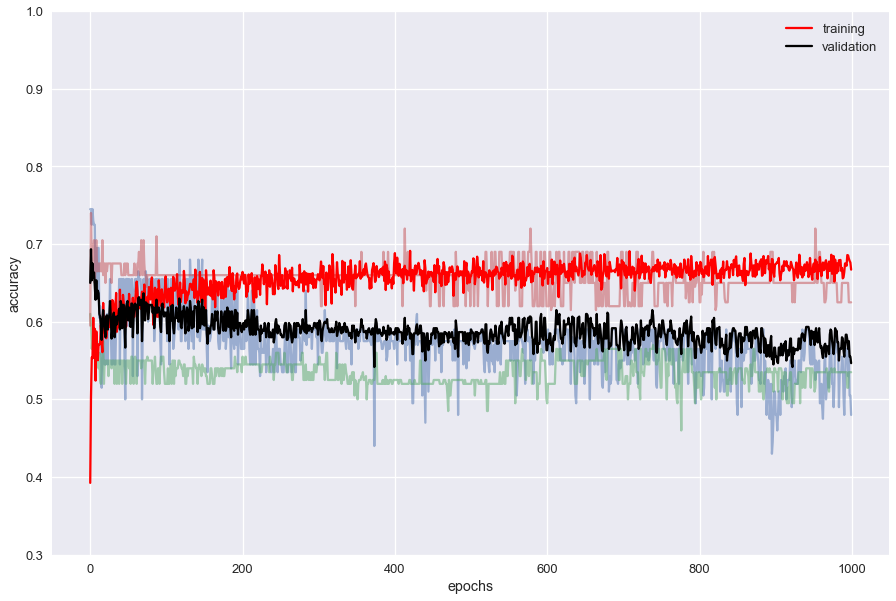

In [236]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
plt.ylim([0.3,1])
x = np.arange(len(histories[0][0].history['val_categorical_accuracy']))
[plt.plot(x,h.history['val_categorical_accuracy'],alpha=.5) for h in histories[0]];
plt.plot(x,np.mean([h.history['categorical_accuracy'] for h in histories[0]],axis=0),c='red', label='training')
plt.plot(x,np.mean([h.history['val_categorical_accuracy'] for h in histories[0]],axis=0),c='black', label='validation')
# plt.plot(n,[0.619]*4000, c='yellow', linewidth=10, alpha=.5, label='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
[plt.plot(np.arange(4000),h.history['val_loss'],alpha=.5) for h in histories];
plt.plot(np.arange(4000),np.mean([h.history['loss'] for h in histories],axis=0),c='red', label='training')
plt.plot(np.arange(4000),np.mean([h.history['val_loss'] for h in histories],axis=0),c='black', label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [ ]:
val_acc

In [ ]:
val_acc

In [ ]:
val_acc

In [ ]:
model = load_model('4000epoch_0,9dropout_woFC_wBI.h5', custom_objects={'seq_len': seq_len})

In [ ]:
# categorical accuracy (this is a bit skewed since it looks at the each link. 
#                       Since most of them are 0 paddings, accuracy is much higher than it really is...)
model.evaluate(X_test, Y_test)

In [ ]:
# Real Accuracy... (i.e. ratio of test samples that are completely correct predicted)
#                   not accounting for what has been predicted for the paddings
total_docs = len(Y_test)
total_links = sum([len(y[:i]) for y, i in zip(Y_test.argmax(-1), Y_test_ind)])

print('document accuracy', sum([np.array_equal(p[:i],y[:i]) for p,y,i in zip(np.argmax(histories[3].model.predict(X_test),-1), Y_test.argmax(-1), Y_test_ind)]) / total_docs)
print('link accuracy', sum([sum(p[:i] == y[:i]) for p,y,i in zip(np.argmax(histories[3].model.predict(X_test),-1),Y_test.argmax(-1), Y_test_ind)]) / total_links)

In [ ]:
sum([len(y[:i]) for y, i in zip(Y_test.argmax(-1), Y_test_ind)])

In [ ]:
sum([np.array_equal(p,y) for p,y in zip(np.argmax(model.predict(X_test),-1),Y_test.argmax(-1))])

In [ ]:
# compare predictions on training set with training labels
list(zip(models[-1].predict(X_train).argmax(-1), Y_train.argmax(-1)))

In [ ]:
list(zip(model.predict(X_test).argmax(-1), Y_test.argmax(-1)))

In [ ]:
plot_model(model, to_file='model_withoutloop.png')

In [ ]:
!open 'model_withoutloop.png'